<a href="https://colab.research.google.com/github/xxxuz1/image_classfication/blob/main/proj3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Recommender Systems

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from surprise import Dataset, KNNBasic, Reader
from surprise.model_selection import cross_validate

sns.set()
plt.rcParams['figure.dpi'] = 150

## Explore the Dataset

In [ ]:
ratings = pd.read_csv('ratings.csv', index_col=0)

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,496,112852,3.0,1415520462
1,391,1947,4.0,1030945141
2,387,1562,1.5,1095041022
3,474,2716,4.5,1053020930
4,483,88125,4.5,1311337237


### Compute the sparsity of the movie rating dataset

In [ ]:
print(
    f'Sparsity of the movie rating dataset: {len(ratings) * 100 / (ratings.userId.nunique() * ratings.movieId.nunique()):.2f}%'
)

Sparsity of the movie rating dataset: 1.70%


### Plot a histogram showing the frequency of the rating values

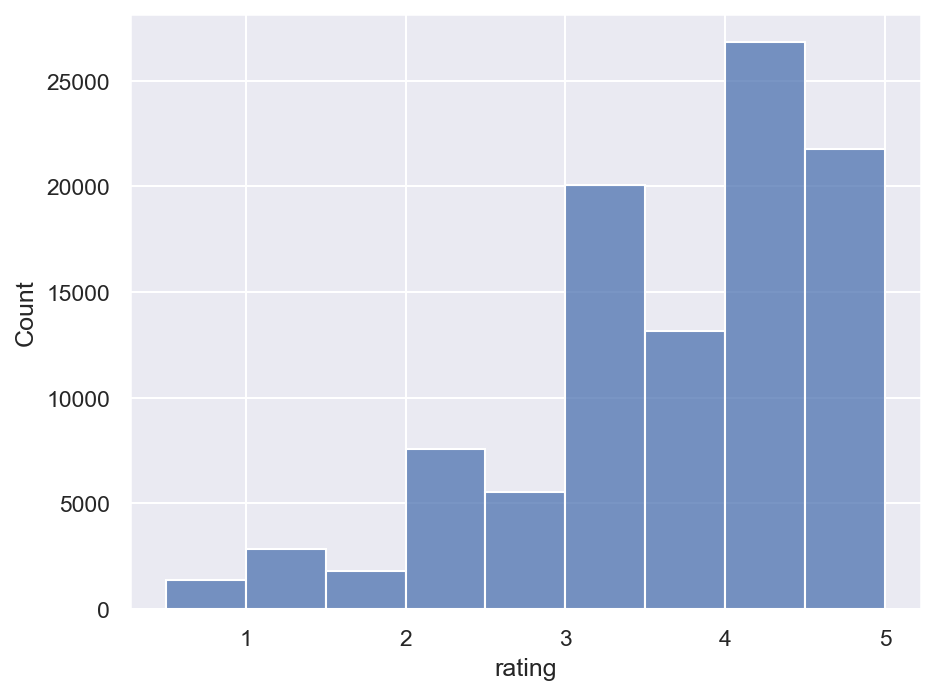

In [ ]:
sns.histplot(ratings.rating, binwidth=0.5)
plt.tight_layout()
plt.show()

### Plot the distribution of the number of ratings received among movies

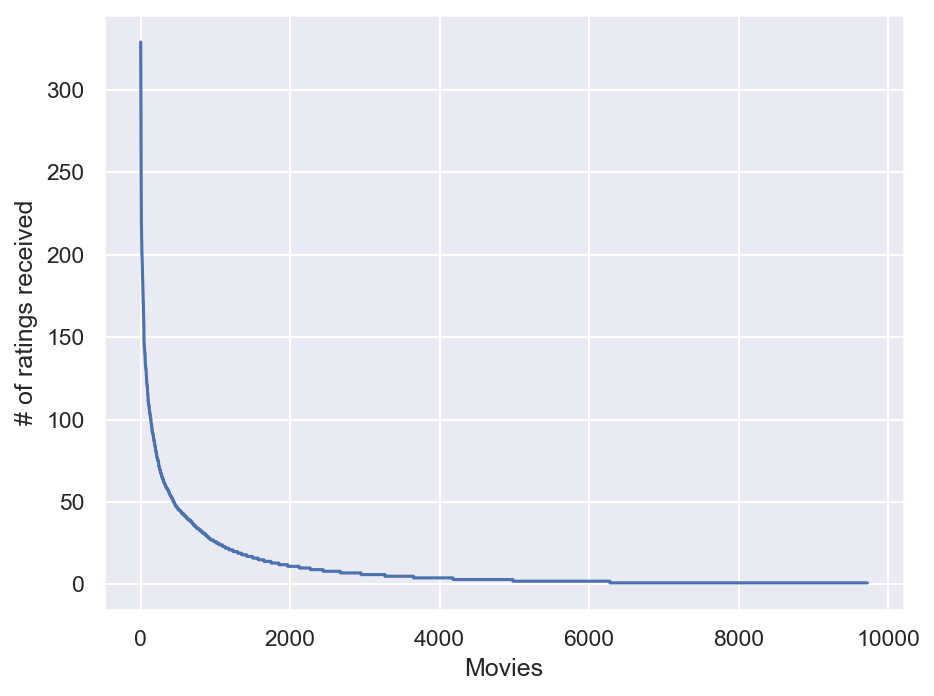

In [ ]:
movie_counts = ratings.movieId.value_counts()
plt.plot(np.arange(len(movie_counts)), movie_counts.to_list())
plt.xlabel('Movies')
plt.ylabel('# of ratings received')
plt.tight_layout()
plt.show()

### Plot the distribution of ratings among users

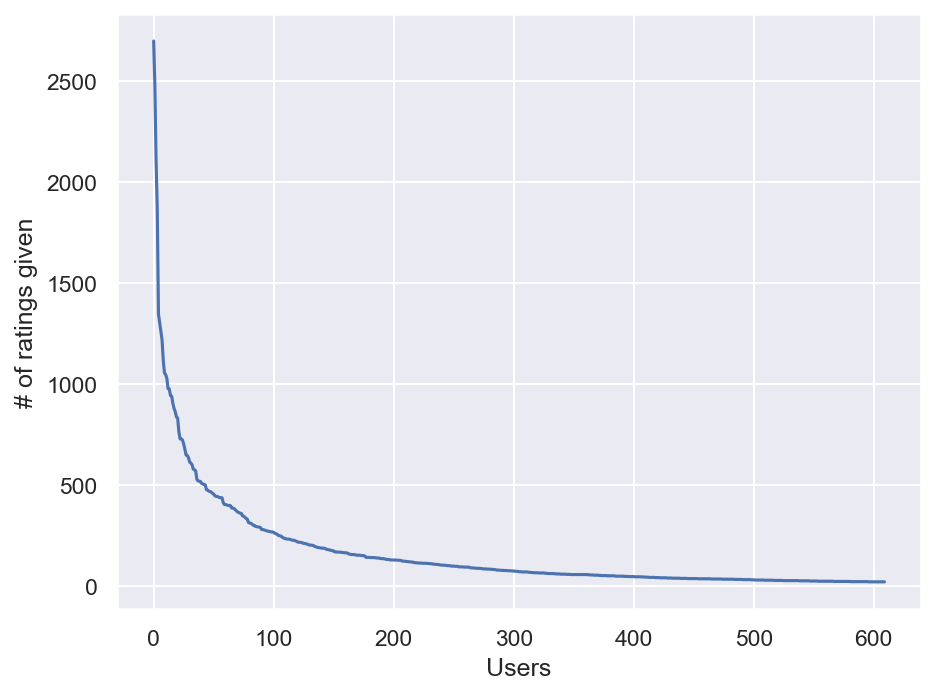

In [ ]:
user_counts = ratings.userId.value_counts()
plt.plot(np.arange(len(user_counts)), user_counts.to_list())
plt.xlabel('Users')
plt.ylabel('# of ratings given')
plt.tight_layout()
plt.show()

### Compute the variance of the rating values received by each movie

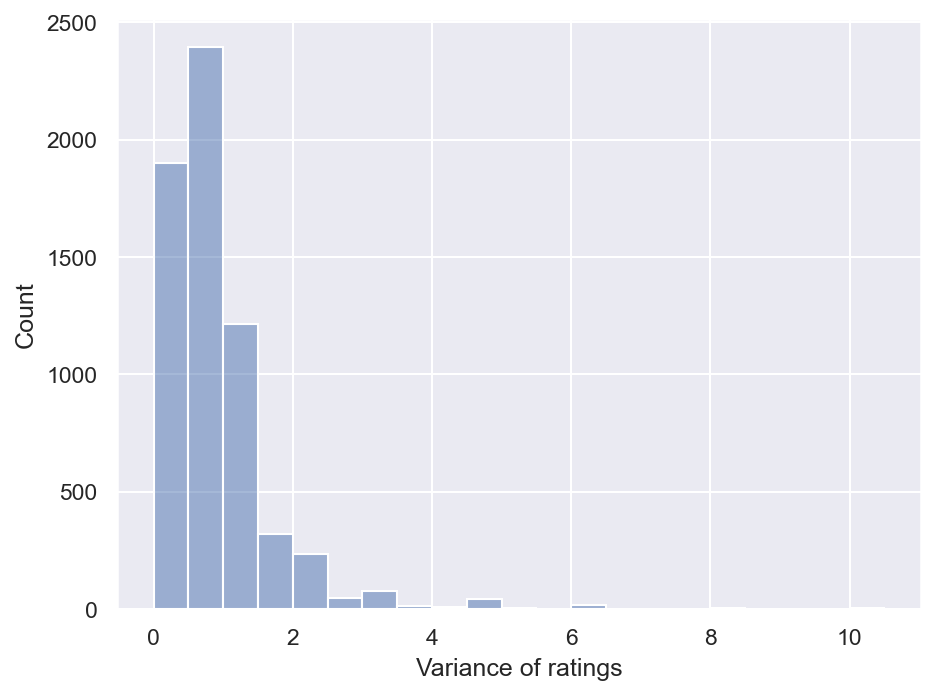

In [ ]:
ax = sns.histplot(ratings[['movieId', 'rating']].groupby('movieId').var(), binwidth=0.5, legend=None)
ax.set_xlabel('Variance of ratings')
plt.tight_layout()
plt.show()

## Neighborhood-based collaborative filtering

###  k-NN collaborative filter

In [ ]:
reader = Reader(rating_scale=(0.5, 5))
ratings_train = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

sim_options = {
    'name': 'pearson',
    'user_based': True
}

rmse_results, mae_results = [], []

for k in tqdm.tqdm(np.arange(2, 101, 2)):
    cv_result = cross_validate(KNNBasic(k=k, sim_options=sim_options, verbose=False), ratings_train, cv=10, n_jobs=-1)
    rmse_results.append(np.mean(cv_result['test_rmse']))
    mae_results.append(np.mean(cv_result['test_mae']))

100%|██████████| 50/50 [01:47<00:00,  2.14s/it]


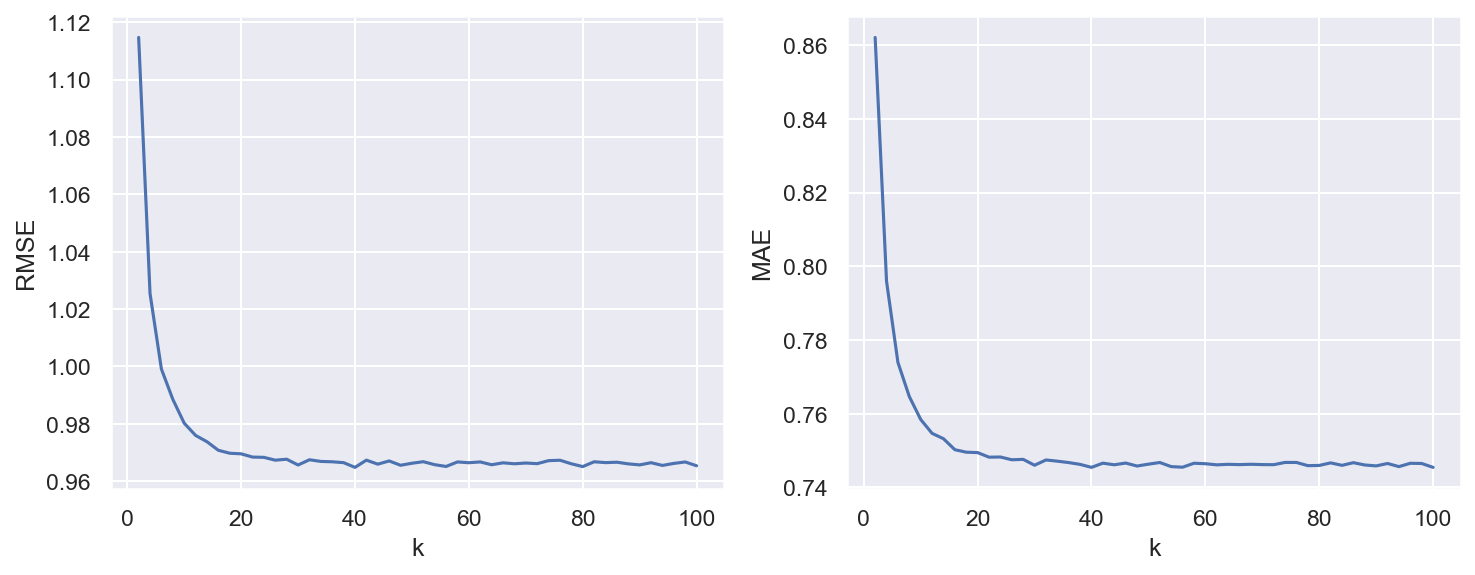

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(np.arange(2, 101, 2), rmse_results)
ax[0].set(xlabel='k', ylabel='RMSE')

ax[1].plot(np.arange(2, 101, 2), mae_results)
ax[1].set(xlabel='k', ylabel='MAE')

plt.tight_layout()
plt.show()

In [ ]:
print(
    f'Steady values of average RMSE: {np.mean(rmse_results[10:]):.3f}, MAE: {np.mean(mae_results[10:]):.3f}'
)

Steady values of average RMSE: 0.966, MAE: 0.746


###  Filter model performance based on subsets of the raw data

In [ ]:
popular_movies = movie_counts.loc[movie_counts > 2].index
unpopular_movies = movie_counts.loc[movie_counts <= 2].index

ratings_var = ratings.loc[ratings['movieId'].isin(movie_counts.loc[movie_counts >= 5].index)].groupby('movieId').var().rating
high_variance_movies = ratings_var.loc[ratings_var >= 2].index

In [ ]:
popular_data = ratings.loc[ratings['movieId'].isin(popular_movies)]
unpopular_data = ratings.loc[ratings['movieId'].isin(unpopular_movies)]
high_variance_data = ratings.loc[ratings['movieId'].isin(high_variance_movies)]

100%|██████████| 50/50 [00:00<00:00, 95.14it/s]


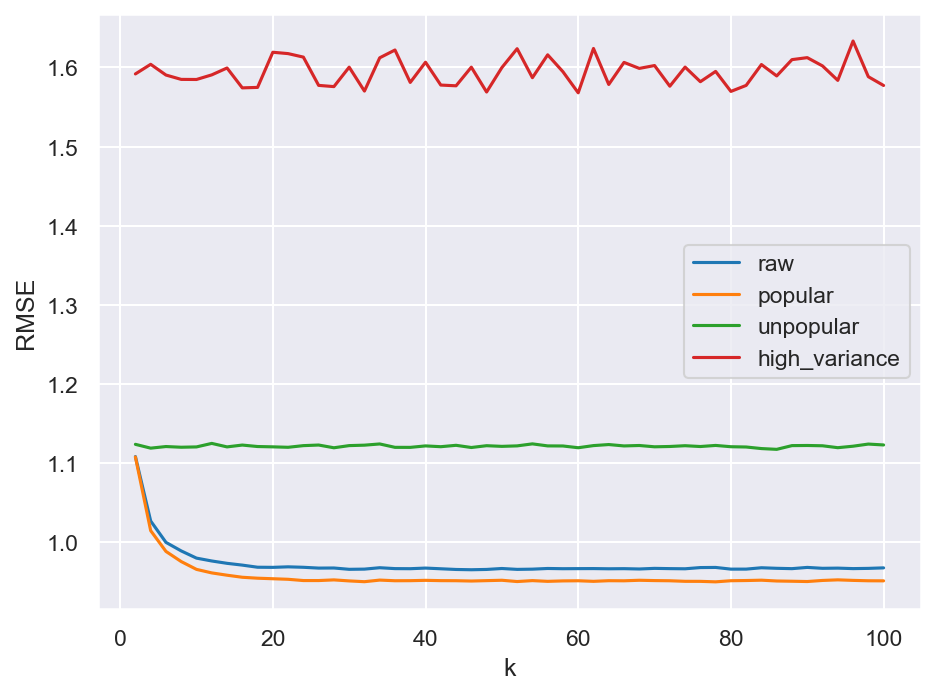

In [ ]:
dataset_map = {
    'raw': ratings,
    'popular': popular_data,
    'unpopular': unpopular_data,
    "high_variance": high_variance_data
}

color_map = {
    'raw': 'tab:blue',
    'popular': 'tab:orange',
    'unpopular': 'tab:green',
    "high_variance": 'tab:red'
}

for trim_method in dataset_map.keys():

    X_train = Dataset.load_from_df(dataset_map[trim_method][['userId', 'movieId', 'rating']], reader)
    rmse_results = []

    for k in tqdm.tqdm(np.arange(2, 101, 2)):
        cv_result = cross_validate(KNNBasic(k=k, sim_options=sim_options, verbose=False), X_train, cv=10, n_jobs=-1)
        rmse_results.append(np.mean(cv_result['test_rmse']))

    plt.plot(np.arange(2, 101, 2), rmse_results, label=trim_method, c=color_map[trim_method])

plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend(loc='best') 
plt.tight_layout()
plt.show()

AUC scores for raw dataset:
	Threshold: 2.5, AUC: 0.725
	Threshold: 3.0, AUC: 0.721
	Threshold: 3.5, AUC: 0.715
	Threshold: 4.0, AUC: 0.708
AUC scores for popular dataset:
	Threshold: 2.5, AUC: 0.725
	Threshold: 3.0, AUC: 0.717
	Threshold: 3.5, AUC: 0.712
	Threshold: 4.0, AUC: 0.702
AUC scores for unpopular dataset:
	Threshold: 2.5, AUC: 0.545
	Threshold: 3.0, AUC: 0.528
	Threshold: 3.5, AUC: 0.526
	Threshold: 4.0, AUC: 0.518
AUC scores for high_variance dataset:
	Threshold: 2.5, AUC: 0.684
	Threshold: 3.0, AUC: 0.677
	Threshold: 3.5, AUC: 0.604
	Threshold: 4.0, AUC: 0.603


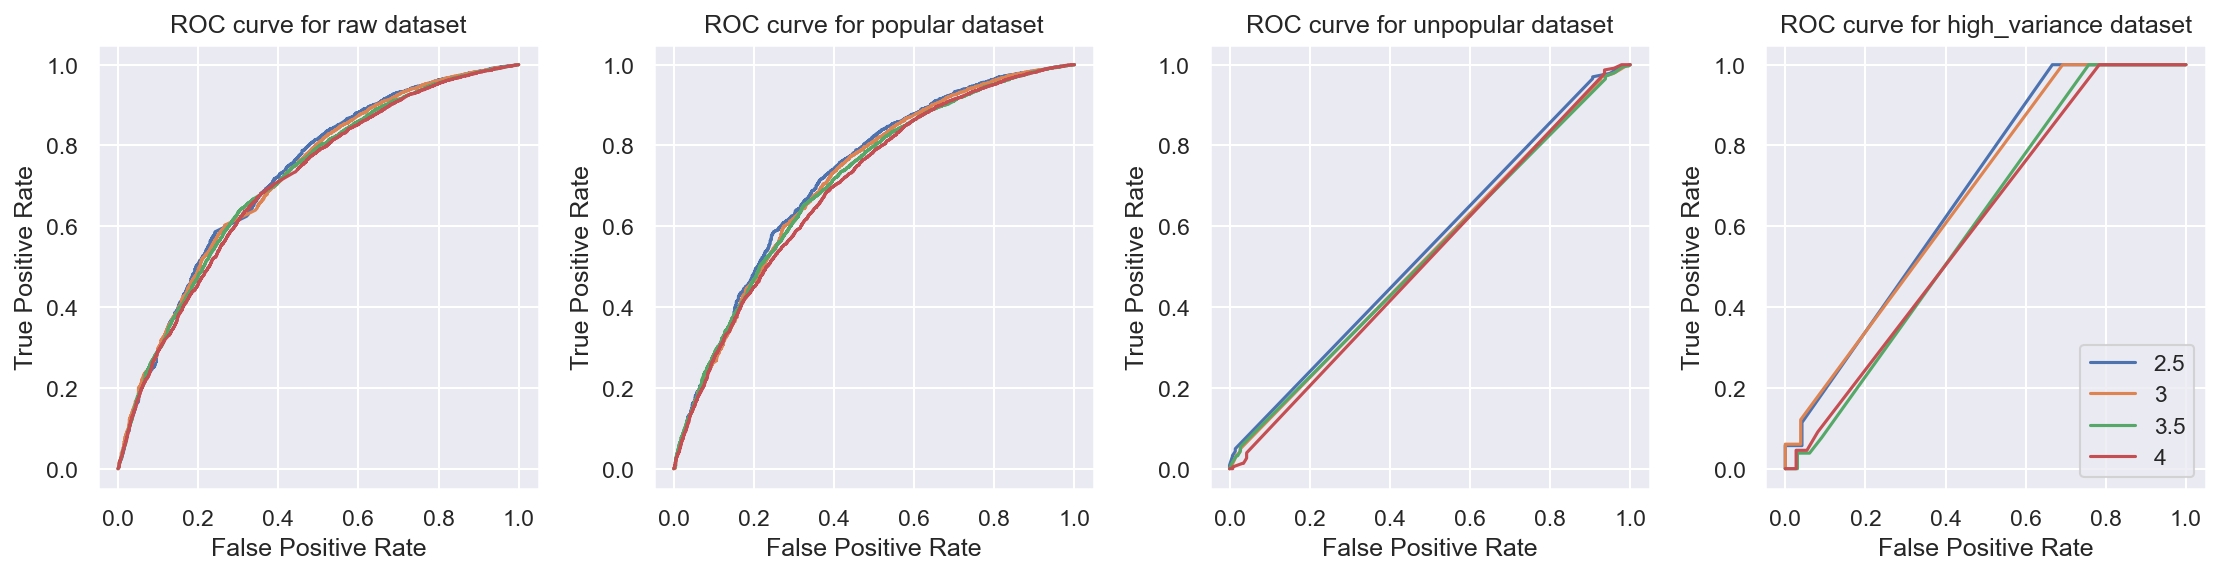

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 4))

for i, trim_method in enumerate(dataset_map.keys()):

    curr_train, curr_test = train_test_split(dataset_map[trim_method], train_size=0.9, shuffle=True)
    X_train = Dataset.load_from_df(curr_train[['userId', 'movieId', 'rating']], reader).build_full_trainset()

    print(f'AUC scores for {trim_method} dataset:')
    
    for t in [2.5, 3, 3.5, 4]:
        y_true = curr_test.rating.apply(lambda x: 1 if x >= t else 0)

        knn = KNNBasic(k=20, sim_options=sim_options, verbose=False)
        knn.fit(X_train)

        y_pred = []

        for _, row in curr_test.iterrows():
            y_pred.append(knn.predict(row.userId, row.movieId).est)

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        print(f'\tThreshold: {t:.1f}, AUC: {roc_auc_score(y_true, y_pred):.3f}')
        ax[i].plot(fpr, tpr, label=t)
        ax[i].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title=f'ROC curve for {trim_method} dataset')

ax[3].legend(loc='lower right')
plt.tight_layout()
plt.show()